In [1]:
import pandas as pd
import sys
import snowflake.connector
import requests
import numpy as np
import glob
import re
import json
import re
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict

In [2]:
con = snowflake.connector.connect(user='axel.tapia@scale.com',
                                  account='pxa65918',
                                  authenticator='externalbrowser',
                                  warehouse='COMPUTE_WH',
                                  database='SCALE_PROD',
                                  role='GENERAL_RO')

cs = con.cursor()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [3]:
BaseQuery = '''
with moves as (
  select
    date_trunc(week, wte.timestamp :: date) as move_date,
    wte.worker as worker_id,
    wt_rf.name as Removed_from_WT,
    wt_at.name as Added_to_WT,
    wte.reason,
    case
      when Added_to_WT in (
        'Generative AI/Chihuahua/Confirmed Cheaters',
        'Free Agent/Banned',
        'Free Agent/Generative AI/Low Quality',
        'Generative AI/Chihuahua/Low Quality',
        'Free Agent/Suspicious_behavior/Suspected_Cheating',
        'Free Agent/SUS_UNDER_REVEW'
      ) then 'Removed for Spam/Quality/Cheating'
       when Added_to_WT in (
        'Generative AI/Chihuahua/RJ/Soul',
'Generative AI/Chihuahua/RJ/Growth'
      ) then 'Failed Certification Exam'
      when Added_to_WT in (
        'Generative AI/Chihuahua/ST/Economics',
        'Generative AI/Chihuahua/AdvMath',
        'Generative AI/Chihuahua/ST/CivEng',
        'Generative AI/Chihuahua/Geometry',
        'Generative AI/Chihuahua/EarthSciences',
        'Outlier/Onboarding/Account Created',
        'Generative AI/Chihuahua/ST/ChemEng',
        'Generative AI/Chihuahua/EarthSciences/L0 reviewers',
        'Generative AI/Chihuahua/Trigonometry/L0 Reviewers',
        'Generative AI/Chihuahua/Algebra',
        'Generative AI/Chihuahua/ElectricalEng',
        'Generative AI/Chihuahua/ComputerSciences',
        'Generative AI/Chihuahua/AdvPhysics',
        'Generative AI/Chihuahua/Precalculus',
        'Generative AI/Chihuahua/Prealgebra',
        'Generative AI/Chihuahua/CivEng',
        'Generative AI/Chihuahua/Geometry/L0 Reviewers',
        'Generative AI/Chihuahua/Nursing',
        'Generative AI/Chihuahua/Accounting',
        'Generative AI/Chihuahua/Trigonometry',
        'Generative AI/Chihuahua/Physics',
        'Generative AI/Chihuahua/ProbStat',
        'Generative AI/Chihuahua/ProbStat/L0 Reviewers',
        'Generative AI/Chihuahua/AdvPhysics/L0 Reviewers',
        'Generative AI/Chihuahua/ST/Chemistry',
        'Generative AI/Chihuahua/Anatomy',
        'Generative AI/Chihuahua/Psychology',
        'Generative AI/Chihuahua/Economics/L0 Reviewers',
        'Generative AI/Chihuahua/Calculus',
        'Generative AI/Chihuahua/AdvMath/L0 reviewers',
        'Generative AI/Chihuahua/Chemistry',
        'Generative AI/Chihuahua/Physics/L0 Reviewers',
        'Generative AI/Chihuahua/Precalculus/L0 Reviewers',
        'Generative AI/Chihuahua/OtherMath/L0 Reviewers',
        'Generative AI/Chihuahua/MechanicalEng',
        'Generative AI/Chihuahua/Calculus/L0 reviewers',
        'Generative AI/Chihuahua/Economics',
        'Generative AI/Chihuahua/Algebra/L0 reviewers',
        'Generative AI/Chihuahua/Anatomy/L0 Reviewers',
        'Generative AI/Chihuahua/OtherMath',
        'Generative AI/Chihuahua/ComputerSciences/L0 reviewers',
        'Generative AI/Chihuahua/ChemEng/L0 Reviewers',
        'Generative AI/Chihuahua/OperationsManagement',
        'Generative AI/Chihuahua/Finance',
        'Generative AI/Chihuahua/CivEng/L0 Reviewers',
        'Generative AI/Chihuahua/ElectricalEng/L0 Reviewers',
        'Generative AI/Chihuahua/Finance/L0 Reviewers',
        'Generative AI/Chihuahua/Nursing/L0 Reviewers',
        'Generative AI/Chihuahua/MechanicalEng/L0 Reviewers',
        'Generative AI/Chihuahua/Biology',
        'Generative AI/Chihuahua/ChemEng',
        'Generative AI/Chihuahua/Psychology/L0 reviewers',
        'Generative AI/Chihuahua/Prealgebra/L0 reviewers',
        'Generative AI/Chihuahua/Accounting/L0 Reviewers',
        'Generative AI/Chihuahua/OperationsManagement/L0 Reviewers',
        'Generative AI/Chihuahua/Biology/Eval',
        'Generative AI/Chihuahua/Biology/MT Reviewer',
        'Generative AI/Chihuahua/Chemistry/L0 reviewers'
      ) then 'Promoted within Chihuahua'
      when Added_to_WT in (
        'Generative AI/Dolphin/Genesis/Multilingual/Marathi mr-Deva/Training',
        'Generative AI/Dolphin/Genesis/Multilingual/Malayalam ml-IN/Training',
        'Dolphin Genesis - Domain Expert - Onboarding',
        'Coders Onboarding/Verification Stage',
        'Generative AI/Bulba/Production/MathGen',
        'Free Agent/Gen AI Holding',
        'Flamingo WFE/Generalists',
        'Generative AI/Bee/Pollination/Peony',
        '2D/Bee/Food Annotation/VE_Bootcamp',
        'Flamingo_Reasoning/L0_raters',
        'Generative AI/Chatbot/Chatbot Training/Experts/Health/Psychology',
        'Generative AI/Chatbot/Chatbot Training/Experts/Data Science & Programming/Coders Tier 3/Staging',
        'Generative AI/Platinum/Generalists/Rating',
        'Generative AI/Bulba/Production/Experts Writers/Marketing_Sales',
        'Generative AI/Platinum/Generalists/Writing',
        'Generative AI/Chatbot/Chatbot Training/Experts/STEM/Biology',
        'Generative AI/Ostrich/SC Translation/Training',
        'Generative AI/Bulba/Production/Experts Writers/Fitness',
        'Experts Landing',
        'Generative AI/Flamingo/FAIR SFT/Experts',
        'Coders Onboarding/Hackerrank Primary',
        'Generative AI/Bulba/Code/Code Eval/Rating/Production/Rating - CrC T1',
        'Generative AI/Bulba/Code/Dev Eval/Rating/Production/Rating - CrC T1',
        'Coders/Failed Second Chance HackerRank',
        'Generative AI/Bulba/Code/Code Eval/Rating/Production/Rating - CrC T2',
        'Generative AI/Bulba/Production/Experts Writers',
        'Generative AI/Crab/GlacierRatSTEM'
      ) then 'Moved to GenAI'
      else 'Awaiting Reallocation'
    end as Worker_Journey
  from EVENTS.WORKER_TEAM_EVENT wte
  join scale_prod.public.workerteams wt_at on wte.ADDED_TO_TEAM = wt_at._id
  join scale_prod.public.workerteams wt_rf on wte.REMOVED_FROM_TEAM = wt_rf._id
  join users u on wte.worker = u._id
  left join users u2 on wte.CORP_USER = u2._id
  where move_date > DATEADD(DAY, -180, GETDATE())
  and wt_rf.name ilike 'Generative AI/Chihuahua%'
)
,aux1 as (
select
u._id as worker_id,
array_agg(T.NAME) all_tags,
    case
      when all_tags :: string ilike '%Soul_IN_BPO_do_not_allocate%' then 'From_Soul'
      when all_tags :: string ilike '%growth%' then 'From_Growth'
      else 'other'
    end as Worker_source_new
  from scale_prod.public.users u
  join ( select _ID, NAME from scale_prod.public.tags ) T on contains(u.tags, T._id)
  where u._id in ( select worker_id from moves )
  group by 1
)
select m.*, Worker_source_new
from moves m
left join aux1 on m.worker_id = aux1.worker_id
where Worker_source_new in ('From_Soul', 'From_Growth')
'''
cs.execute(BaseQuery)
BaseDF = cs.fetch_pandas_all()

In [4]:
BaseDF

,MOVE_DATE,WORKER_ID,REMOVED_FROM_WT,ADDED_TO_WT,REASON,WORKER_JOURNEY,WORKER_SOURCE_NEW
0,2023-09-25,650d268c932c9171e30a2b2e,Generative AI/Chihuahua,Generative AI/Chihuahua/MechanicalEng,Manual move via corp,Promoted within Chihuahua,From_Soul
1,2023-10-23,650d268c932c9171e30a2b2e,Generative AI/Chihuahua/MechanicalEng,Free Agent/Inactive,Funneled starting from funnel node 64e509a3829...,Awaiting Reallocation,From_Soul
2,2023-10-23,6530bada3c780d92908ddbcb,Generative AI/Chihuahua,Generative AI/Chihuahua/CivEng,Manual move via corp,Promoted within Chihuahua,From_Soul
3,2023-09-18,650a8097e2fee779d506a1c8,Generative AI/Chihuahua,Generative AI/Chihuahua/MechanicalEng,Manual move via corp,Promoted within Chihuahua,From_Soul
4,2023-10-02,650a8097e2fee779d506a1c8,Generative AI/Chihuahua/MechanicalEng,Generative AI/Chihuahua/RJ/Soul,Manual move via corp,Failed Certification Exam,From_Soul
...,...,...,...,...,...,...,...
6195,2023-10-02,647037bf32cf2787049d6285,Generative AI/Chihuahua/Biology,Free Agent/Gen AI Holding,Inactive taskers movement,Moved to GenAI,From_Growth
6196,2023-08-21,647037bf32cf2787049d6285,Generative AI/Chihuahua/Biology,Free Agent/Inactive,Funneled starting from funnel node 64d41f5fbda...,Awaiting Reallocation,From_Growth
6197,2023-09-04,647037bf32cf2787049d6285,Generative AI/Chihuahua/Biology,Free Agent/Gen AI Holding,Inactive taskers movement,Moved to GenAI,From_Growth
6198,2023-10-09,6504c304ea361cf7ee344e6d,Generative AI/Chihuahua/OperationsManagement,Free Agent/Inactive,Funneled starting from funnel node 64e5087e6d2...,Awaiting Reallocation,From_Soul


In [20]:
grouped_data = BaseDF.groupby(['MOVE_DATE', 'WORKER_SOURCE_NEW', 'WORKER_JOURNEY']).size().reset_index(name='count')
pivot_table = grouped_data.pivot_table(index='MOVE_DATE', columns=['WORKER_SOURCE_NEW', 'WORKER_JOURNEY'], values='count', fill_value=0)
df_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
df_percentage=df_percentage.round(2)

<Figure size 432x288 with 0 Axes>

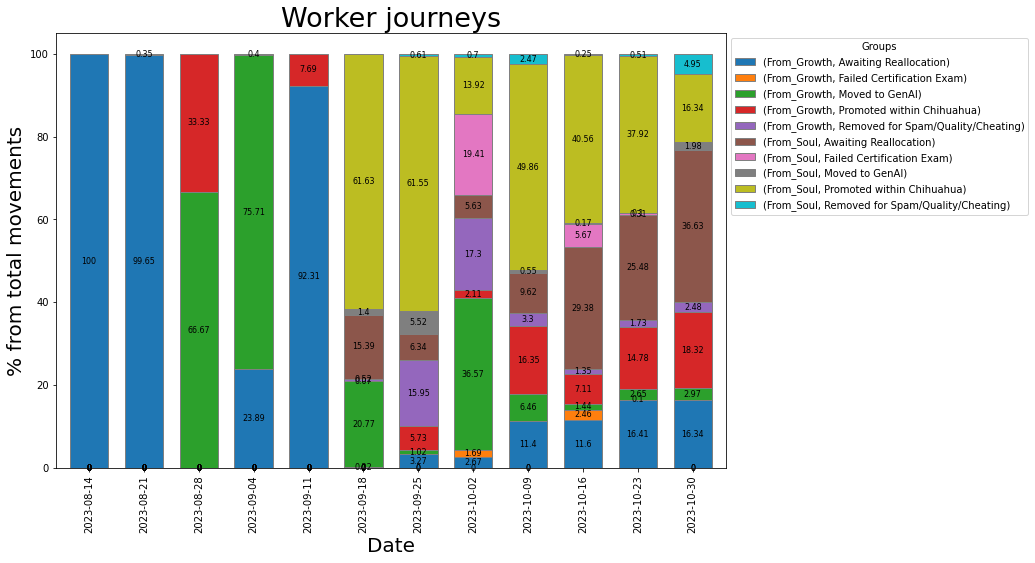

In [45]:
plt.figure(facecolor='#f8f9fa')
ax = df_percentage.plot(kind='bar', stacked=True,width=0.7, figsize=(12, 8), edgecolor='gray')
ax.set_ylabel('% from total movements',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Worker journeys',fontsize=27)
for container in ax.containers:
    ax.bar_label(container, label_type='center',color='black',size=8)

# Adding legend
ax.legend(title='Groups',bbox_to_anchor=(1,1))

# Adding grid
#ax.grid(color='lightgray', linestyle='--', linewidth=0.3)

# Show plot
plt.show()

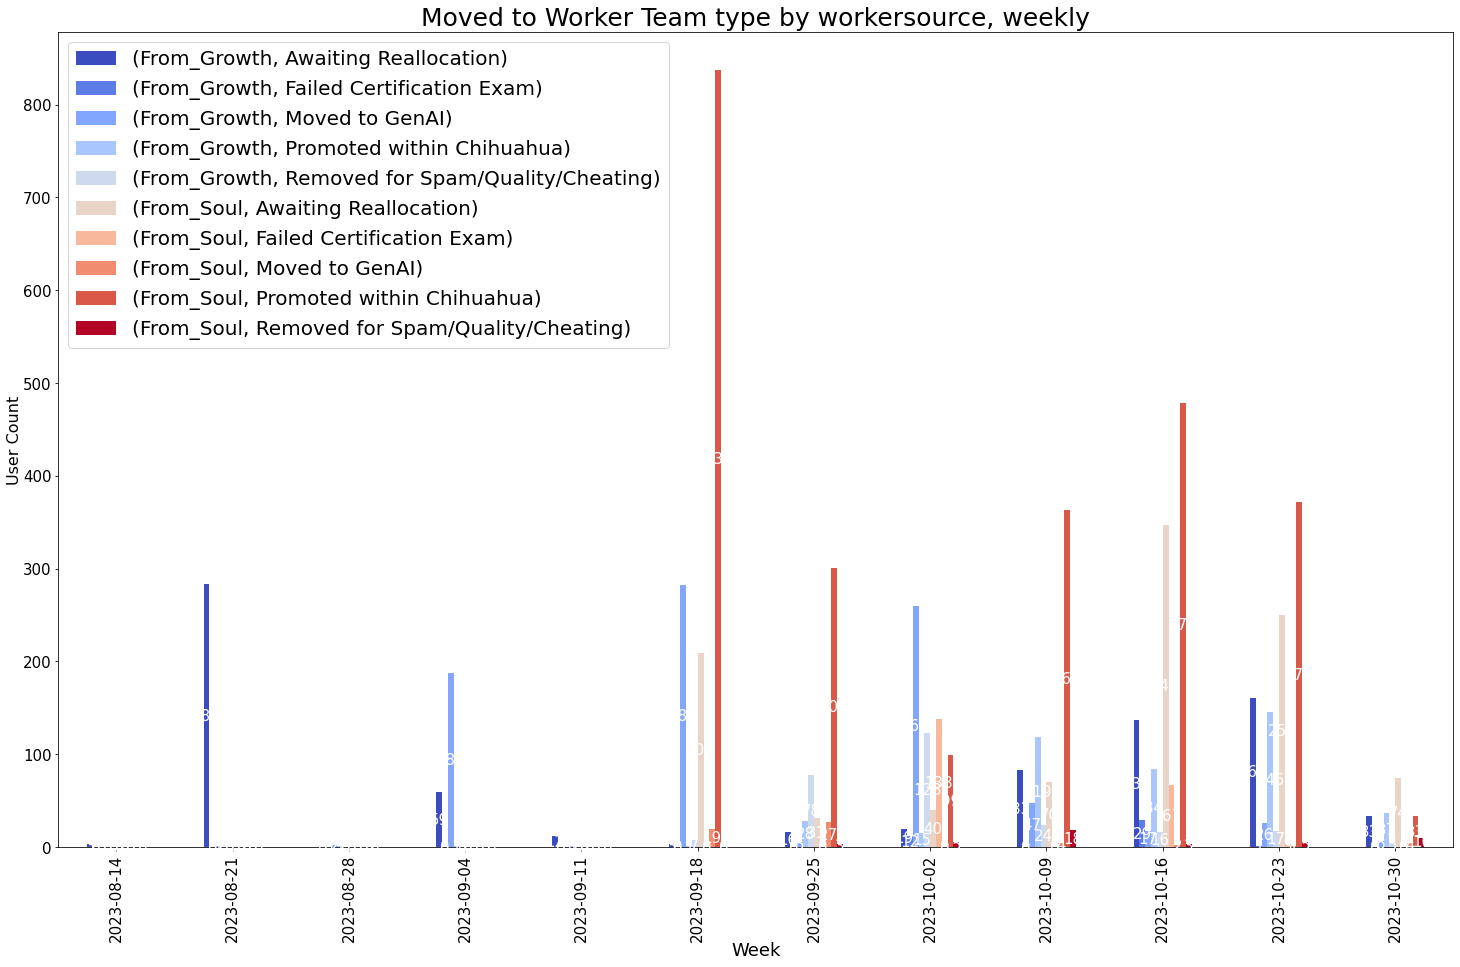

<Figure size 432x288 with 0 Axes>

In [9]:
ax=pivot_table.plot(kind='bar', stacked=False,figsize=(25,15),colormap='coolwarm')
plt.title('Moved to Worker Team type by workersource, weekly',size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize="20", loc ="upper left")
plt.xlabel('Week', labelpad=.5,fontsize=18)
plt.ylabel('User Count', labelpad=.5,fontsize=16)
for container in ax.containers:
    ax.bar_label(container, label_type='center',color='white',size=15)

plt.show()
plt.draw()

In [124]:
TagsQuery = '''
with chihuahua_projects as (select _id from scale_prod.public.projects where name ilike '%chihuahua%')

,historic_taskers as (select distinct attempted_by from scale_prod.public.taskattempts where project in (select distinct _ID from chihuahua_projects))

,current_taskers as (
select
 u._id as worker_id
,case when   wt.name ilike 'Generative AI/Chihuahua%' then 'current_tasker' else 'removed_tasker' end as Tasker_Status
,array_agg(T.NAME) all_tags
,iff(array_to_string(all_tags,',') ilike '%spam%'                ,true,false) has_spammer_tag
,iff(array_to_string(all_tags,',') ilike '%cheat%'                  ,true,false) has_cheated_tag
,iff(array_to_string(all_tags,',') ilike '%ban%'                 ,true,false) has_banned_tag

,case
    when all_tags::string ilike '%Soul_IN_BPO_do_not_allocate%' then 'From_Soul'
    when all_tags::string ilike '%growth%'                      then 'From_Growth'
else 'other' end as Worker_source_new

from scale_prod.public.users u
join scale_prod.public.workerteams wt on u.active_worker_team = wt._id
join (select _ID,NAME from scale_prod.public.tags ) T on contains(u.tags, T._id)
where u._id in (select attempted_by from historic_taskers)
group by 1,2
)

select
Worker_source_new
,count_if(has_spammer_tag ='true')  Spam_True
,count_if(has_spammer_tag <>'true') Spam_False

,count_if(has_cheated_tag ='true') Cheat_True
,count_if(has_cheated_tag <>'true')Cheat_False

,count_if(has_banned_tag  ='true') Ban_True
,count_if(has_banned_tag  <>'true')Ban_False

,DIV0NULL(count_if(has_spammer_tag ='true'),count_if(has_spammer_tag <>'true')) as spammer_tag_ratio
,DIV0NULL(count_if(has_cheated_tag ='true'),count_if(has_cheated_tag <>'true')) as cheated_tag_ratio
,DIV0NULL(count_if(has_banned_tag  ='true'),count_if(has_banned_tag  <>'true')) as banned_tag_ratio
from current_taskers
where Worker_source_new in ( 'From_Soul','From_Growth')
group by 1
'''
cs.execute(TagsQuery)
TagsDF = cs.fetch_pandas_all()

In [125]:
TPQuery='''
with chihuahua_projects as (select _id from scale_prod.public.projects where name ilike '%chihuahua%')

,historic_taskers as (select distinct attempted_by from scale_prod.public.taskattempts where project in (select distinct _ID from chihuahua_projects))

,current_taskers as (
select
 u._id as worker_id
,case when   wt.name ilike 'Generative AI/Chihuahua%' then 'current_tasker' else 'removed_tasker' end as Tasker_Status
,array_agg(T.NAME) all_tags
,iff(array_to_string(all_tags,',') ilike '%spam%'                ,true,false) has_spammer_tag
,iff(array_to_string(all_tags,',') ilike '%cheat%'                  ,true,false) has_cheated_tag
,iff(array_to_string(all_tags,',') ilike '%ban%'                 ,true,false) has_banned_tag

,case
    when all_tags::string ilike '%Soul_IN_BPO_do_not_allocate%' then 'From_Soul'
    when all_tags::string ilike '%growth%'                      then 'From_Growth'
else 'other' end as Worker_source_new

from scale_prod.public.users u
join scale_prod.public.workerteams wt on u.active_worker_team = wt._id
join (select _ID,NAME from scale_prod.public.tags ) T on contains(u.tags, T._id)
where u._id in (select attempted_by from historic_taskers)
group by 1,2
)

select
 fwa.worker
,Worker_source_new
,Tasker_Status
,date_trunc(week,WORK_DATE) as WORK_DATE
,count(distinct(WORK_ID))                                   as Total_Work
from VIEW.FACT_WORK_AGGREGATE fwa
join current_taskers bu on fwa.worker=bu.worker_id
where project in (select distinct _ID from chihuahua_projects)
and bu.Worker_source_new in ('From_Soul','From_Growth')
group by 1,2,3,4
order by fwa.worker ,WORK_DATE asc
'''
cs.execute(TPQuery)
TPDF = cs.fetch_pandas_all()

In [127]:
grouped_data2 = TPDF.groupby(['WORK_DATE', 'WORKER_SOURCE_NEW','TASKER_STATUS']).size().reset_index(name='count')
pivot_table2 = grouped_data2.pivot_table(index='WORK_DATE', columns=['WORKER_SOURCE_NEW','TASKER_STATUS'], values='count',fill_value=0)

WORKER_SOURCE_NEW    From_Growth                     From_Soul               
TASKER_STATUS     current_tasker removed_tasker current_tasker removed_tasker
WORK_DATE                                                                    
2023-06-12                     1              2              0              0
2023-08-14                     0              2              0              0
2023-08-21                     8              2              0              0
2023-08-28                    14             25              0              0
2023-09-04                    20             40              0              0
2023-09-11                    71             76             31              0
2023-09-18                   185            163            290             26
2023-09-25                   244            292            408             32
2023-10-02                   250            216            422             21
2023-10-09                   261             58            455             16
2023-10-16                   271             49            543              5
2023-10-23                   241             19            567              5
2023-10-30                   197              5            501              2

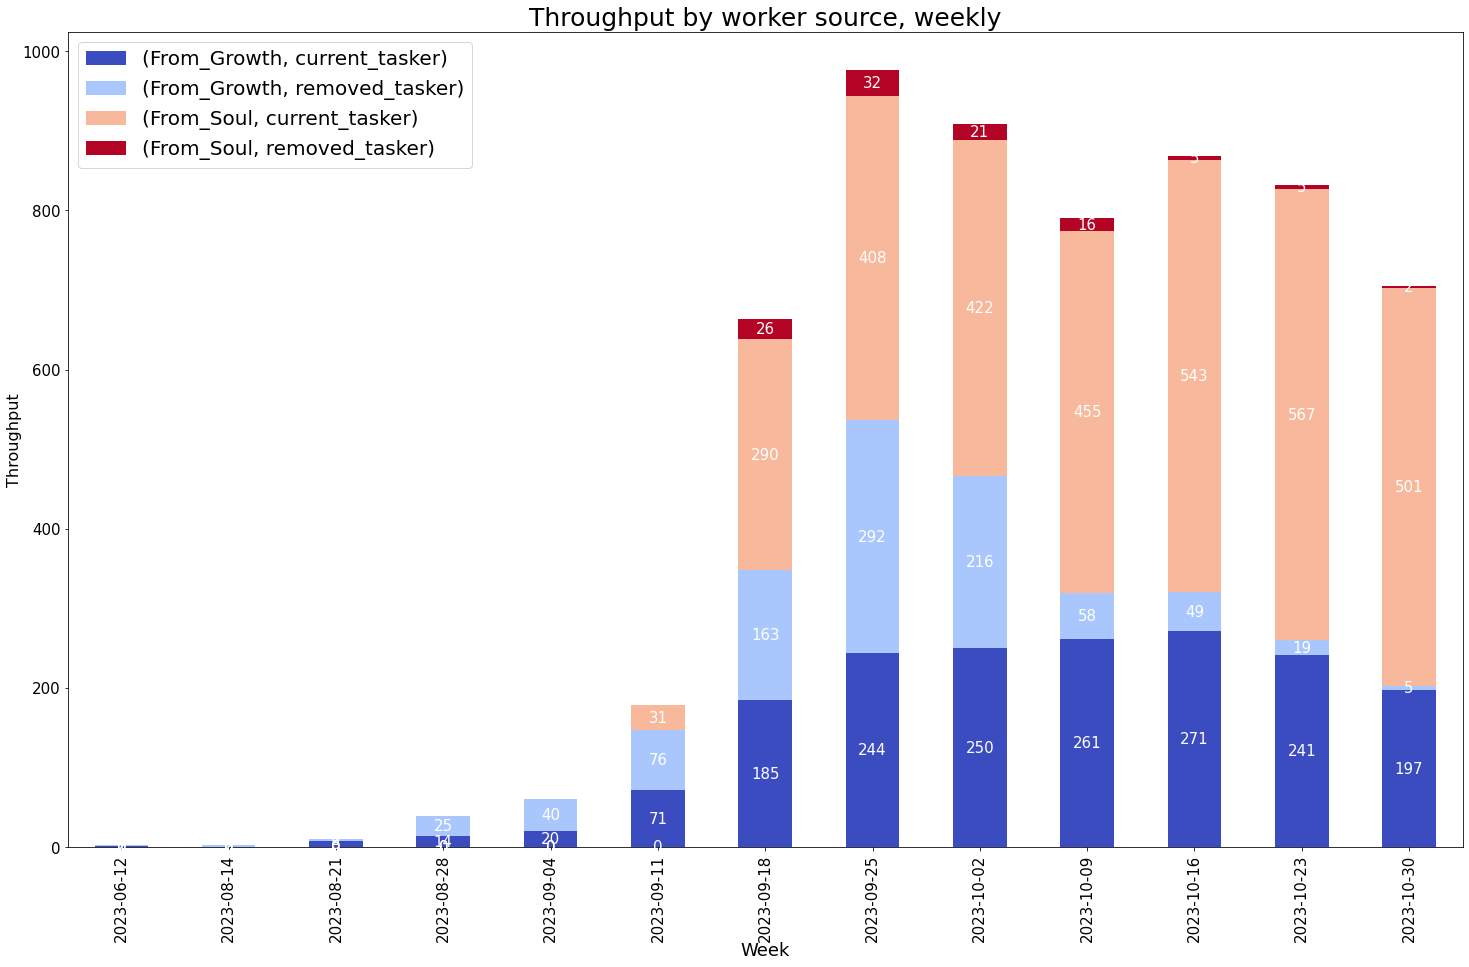

<Figure size 432x288 with 0 Axes>

In [129]:
ax=pivot_table2.plot(kind='bar', stacked=True,figsize=(25,15),colormap='coolwarm')
plt.title('Throughput by worker source, weekly',size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize="20", loc ="upper left")
plt.xlabel('Week', labelpad=.5,fontsize=18)
plt.ylabel('Throughput', labelpad=.5,fontsize=16)
for container in ax.containers:
    ax.bar_label(container, label_type='center',color='white',size=15)

plt.show()
plt.draw()

In [131]:
PayQuery='''
with chihuahua_projects as (select _id from scale_prod.public.projects where name ilike '%chihuahua%')

,historic_taskers as (select distinct attempted_by from scale_prod.public.taskattempts where project in (select distinct _ID from chihuahua_projects))

,current_taskers as (
select
 u._id as worker_id
,case when   wt.name ilike 'Generative AI/Chihuahua%' then 'current_tasker' else 'removed_tasker' end as Tasker_Status
,array_agg(T.NAME) all_tags
,iff(array_to_string(all_tags,',') ilike '%spam%'                ,true,false) has_spammer_tag
,iff(array_to_string(all_tags,',') ilike '%cheat%'                  ,true,false) has_cheated_tag
,iff(array_to_string(all_tags,',') ilike '%ban%'                 ,true,false) has_banned_tag

,case
    when all_tags::string ilike '%Soul_IN_BPO_do_not_allocate%' then 'From_Soul'
    when all_tags::string ilike '%growth%'                      then 'From_Growth'
else 'other' end as Worker_source_new

from scale_prod.public.users u
join scale_prod.public.workerteams wt on u.active_worker_team = wt._id
join (select _ID,NAME from scale_prod.public.tags ) T on contains(u.tags, T._id)
where u._id in (select attempted_by from historic_taskers)
group by 1,2
)

select
 fwa.worker
,Worker_source_new
,Tasker_Status
,date_trunc(week,WORK_DATE) as WORK_DATE
,PAYOUT
--,sum(PAYOUT)                                                as Total_PayOut
--,avg(PAYOUT)                                                as Average_PayOut
--,median(PAYOUT)                                             as Median_PayOut
from VIEW.FACT_WORK_AGGREGATE fwa
join current_taskers bu on fwa.worker=bu.worker_id
where project in (select distinct _ID from chihuahua_projects)
and bu.Worker_source_new in ('From_Soul','From_Growth')
--group by 1,2,3,4
order by fwa.worker ,WORK_DATE asc
'''
cs.execute(PayQuery)
PayDF = cs.fetch_pandas_all()

In [160]:
GrowthSlice=PayDF[PayDF['WORKER_SOURCE_NEW']=='From_Growth']
SoulSlice=PayDF[PayDF['WORKER_SOURCE_NEW']!='From_Growth']

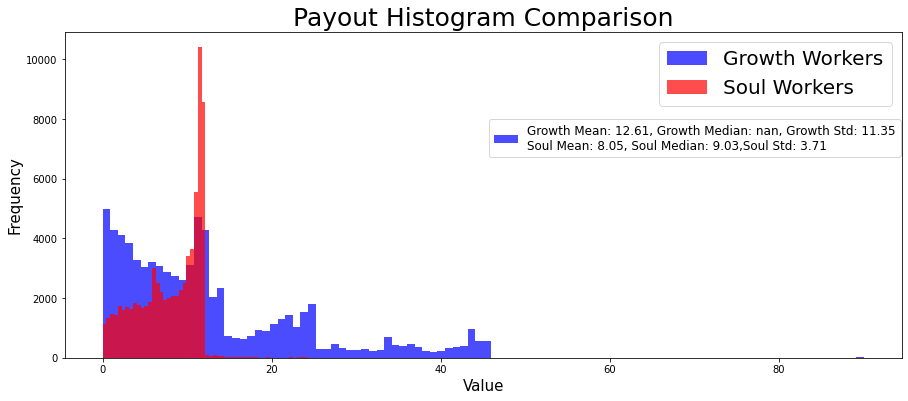

In [218]:
data1 = GrowthSlice['PAYOUT']
data2 = SoulSlice['PAYOUT']

# Calculate mean, median, and standard deviation for each dataset
data1_mean, data1_median, data1_std = np.mean(data1), np.median(data1), np.std(data1)
data2_mean, data2_median, data2_std = np.mean(data2), np.median(data2), np.std(data2)

# Create a new figure
plt.figure(figsize=(15, 6))

# Plot the first histogram
plt.hist(data1, bins=100, alpha=0.7, label='Growth Workers', color='blue')

# Plot the second histogram
plt.hist(data2, bins=100, alpha=0.7, label='Soul Workers', color='red')

# Add a legend for the histograms
legend1 = plt.legend(fontsize="20")

# Add a second legend for mean, median, and standard deviation
legend_text = f'Growth Mean: {data1_mean:.2f}, Growth Median: {data1_median:.2f}, Growth Std: {data1_std:.2f}\n' f'Soul Mean: {data2_mean:.2f}, Soul Median: {data2_median:.2f},Soul Std: {data2_std:.2f}'
plt.legend([legend_text], loc='upper left', bbox_to_anchor=(.5,.75),fontsize="12")

# Add the first legend back to the plot
plt.gca().add_artist(legend1)

# Add title and labels
plt.title('Payout Histogram Comparison',fontsize="25")
plt.xlabel('Value',fontsize="15")
plt.ylabel('Frequency',fontsize="15")

# Show the plot
plt.show()



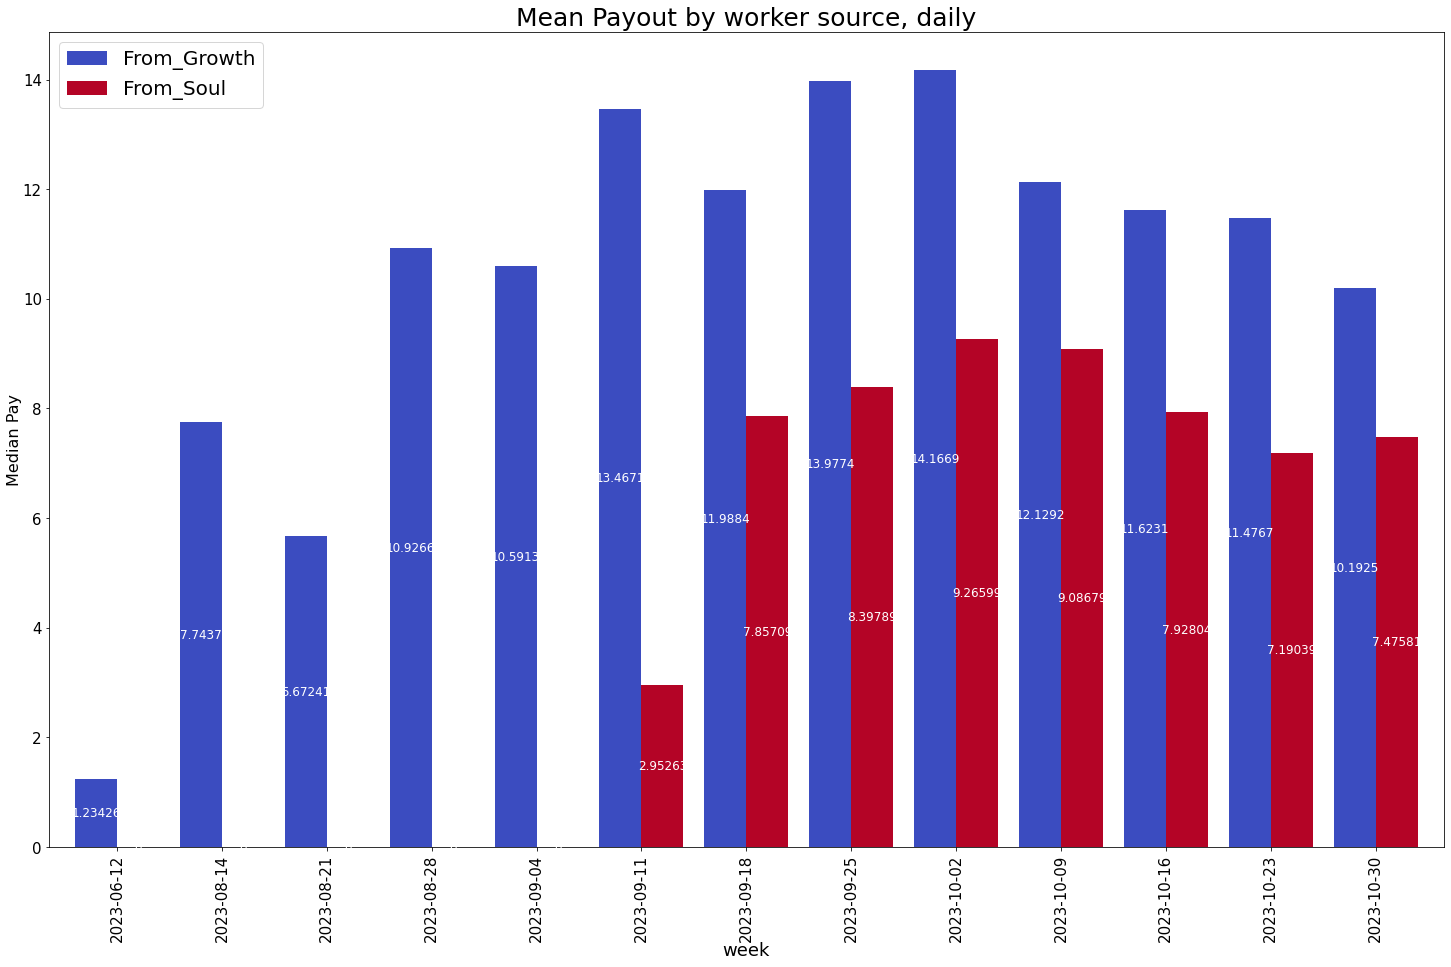

<Figure size 432x288 with 0 Axes>

In [223]:
df = PayDF.groupby(['WORK_DATE', 'WORKER_SOURCE_NEW'])['PAYOUT'].mean().reset_index(name='sum')
pivot_table3 = df.pivot_table(index='WORK_DATE', columns=['WORKER_SOURCE_NEW'], values='sum',fill_value=0)


ax=pivot_table3.plot(kind='bar', width=.8,stacked=False,figsize=(25,15),colormap='coolwarm')
plt.title('Mean Payout by worker source, daily',size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize="20", loc ="upper left")
plt.xlabel('week', labelpad=.5,fontsize=18)
plt.ylabel('Median Pay', labelpad=.5,fontsize=16)
for container in ax.containers:
    ax.bar_label(container, label_type='center',color='white',size=12)

plt.show()
plt.draw()

In [8]:
from email.message import EmailMessage
import ssl
import smtplib
import pandas as pd

In [9]:
#df = pd.read_csv('Scale\Chihuahua\email_list2.csv')
df2= pd.read_csv('Chihuahua_Reviewer_BM_Scores_2023_11_03.csv')

In [10]:
df2

,EMAIL,BM_ATTEMPT,BM_ID,SS_URL
0,scory8617@gmail.com,65414f7fbce916b03c0e37f5,65396bc1fcc1822a75596b03,https://snipboard.io/pGFRU6.jpg
1,mxqa916@mx.remotasks.com,6542ac973f3e8307571aaedd,6538a1ae2e677d419628b5a8,https://snipboard.io/oI9Aem.jpg
2,mxqa841@mx.remotasks.com,6542b847734ffb4be157bf0d,65405100dfbdce8a16646397,https://snipboard.io/kVbgE9.jpg
3,lalitbhardwaj2001asr@gmail.com,65419fdaa22c4d9df07b0733,6540ffc697ce488e144aae3a,https://snipboard.io/EvJLeM.jpg
4,calindyleo@gmail.com,6538a90b39e2cbe3c722c88a,65388a50e2e67f2dfd82797a,https://snipboard.io/awF97s.jpg
...,...,...,...,...
182,tripathi.suryansh7@gmail.com,65451fd593a85b6bf7a668d5,65403e7ff70eb46757f27fcc,https://snipboard.io/nRoM2W.jpg
183,hatorigraal@gmail.com,65435576439550a8cea1553c,65416377e35679f01710fdc1,https://snipboard.io/Ula2uV.jpg
184,mxqa841@mx.remotasks.com,6542b6ac93807729641966ce,65416377e35679f01710fdc1,https://snipboard.io/Ula2uV.jpg
185,mxqa841@mx.remotasks.com,6542b340ad7a8fe34c52a4f8,6540ac1a3a4bfa370a178af0,https://snipboard.io/Amt42c.jpg


In [11]:
email_sender = 'vishal.kumar@remotasks.com'
email_password = 'oitd douy quzf mrpv '

#email_list = ['hrshtdeshmukh@gmail.com', 'ankushpgarg@gmail.com', 'mxqa1215@mx.remotasks.com']
email_list=df2["EMAIL"].unique()

result_dict = {}
keys_string = ""
values_string = ""

for email in email_list:
    combined = ""
    email_data = []
    for index, row in df2.iterrows():
        if row['EMAIL'] == email:
            email_data.append({'Task ID': row['BM_ATTEMPT'], 'Screenshot URL': row['SS_URL']})
            combined += 'Task ID: ' + row['BM_ATTEMPT'] + "\n" + ' Screenshot URL: ' + row['SS_URL'] + "\n"
    result_dict[email] = email_data
    keys_string += email + "\n"

    subject = "We have feedback on your tasks! "
    body = "Hello Reviewer," + "\n" + "\n"\
           + "Thank you for your continued contribution to the Chihuahua Project. It has been tremendously helpful in training our models and accelerating the development of AI. " + "\n" + "\n"\
           + "Please note that we conducted some audits and found some responses where you missed a few details. You can view them in the screenshot/s below:" + "\n" + "\n"\
           + combined + "\n"\
           + "This is not going to impact your pay or reviewer status, but is feedback from us to keep your focus on such misses going forward, as they can introduce issues in model output if not corrected." + "\n" + "\n"\
           + "We value your work." + "\n" + "\n"\
           + "Thanks a lot" + "\n"\
           + ",The Remotasks Team"
    em=EmailMessage()
    em['From'] = email_sender
    em['To']= email
    em['Subject']=subject
    em.set_content(body)
    context=ssl.create_default_context()
    with smtplib.SMTP_SSL('smtp.gmail.com',465,context=context) as smtp:
        smtp.login(email_sender, email_password)
        smtp.sendmail(email_sender, email, em.as_string())
    print(body)

Hello Reviewer,

Thank you for your continued contribution to the Chihuahua Project. It has been tremendously helpful in training our models and accelerating the development of AI. 

Please note that we conducted some audits and found some responses where you missed a few details. You can view them in the screenshot/s below:

Task ID: 65414f7fbce916b03c0e37f5
 Screenshot URL: https://snipboard.io/pGFRU6.jpg
Task ID: 6542f657d62aa5b9455a5940
 Screenshot URL: https://snipboard.io/Aru2fN.jpg
Task ID: 6542b42857e114bdf3d37767
 Screenshot URL: https://snipboard.io/pGFRU6.jpg
Task ID: 6543cfa8b8fa40030ec24e4b
 Screenshot URL: https://snipboard.io/QDsG6U.jpg
Task ID: 654159f034cdfe4176ada2e8
 Screenshot URL: https://snipboard.io/pGFRU6.jpg
Task ID: 6543a142003a2015d5135482
 Screenshot URL: https://snipboard.io/pGFRU6.jpg
Task ID: 6543ebac0a426816d2581e7e
 Screenshot URL: https://snipboard.io/Aru2fN.jpg
Task ID: 6543989921ff1a350b7b25b6
 Screenshot URL: https://snipboard.io/QDsG6U.jpg
Task ID:

SMTPRecipientsRefused: {'yashraj7424@gmail.com+outlier': (553, b'5.1.3 The recipient address <yashraj7424@gmail.com+outlier> is not a valid\n5.1.3 RFC 5321 address. Please visit\n5.1.3  https://support.google.com/a/answer/3221692 and review RFC 5321\n5.1.3 specifications for more information. x14-20020aa793ae000000b0068bc6a75848sm2221663pff.156 - gsmtp')}